In [ ]:
! git clone https://github.com/ml4py/dataset-iiit-pet.git

In [32]:
!mv dataset-iiit-pet/annotations .
!mv dataset-iiit-pet/images .

In [3]:
!git clone https://github.com/ultralytics/yolov5
!pip install -r yolov5/requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 9338, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 9338 (delta 0), reused 0 (delta 0), pack-reused 9337
Receiving objects: 100% (9338/9338), 9.87 MiB | 16.49 MiB/s, done.
Resolving deltas: 100% (6481/6481), done.
     |████████████████████████████████| 636 kB 4.2 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [34]:
import os
import xml.etree.ElementTree as ET
import pickle
from os import listdir, getcwd
from os.path import join
import shutil
import random

In [35]:
!rm -rf labels

In [36]:
classes0 = ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British', 'Egyptian', 'Maine', 'Persian', 'Ragdoll', 'Russian', 'Siamese', 'Sphynx', 'american', 'basset', 'beagle', 'boxer', 'chihuahua', 'english', 'german', 'great', 'havanese', 'japanese', 'keeshond', 'leonberger', 'miniature', 'newfoundland', 'pomeranian', 'pug', 'saint', 'samoyed', 'scottish', 'shiba', 'staffordshire', 'wheaten', 'yorkshire']
classes = ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

def convert(size, box):
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[1])/2.0
    y = (box[2] + box[3])/2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)


def convert_annotation(image_id):
    try:
        in_file = open('annotations/xmls/%s.xml' % image_id)
        out_file = open('labels/%s.txt' % image_id, 'w')
        tree=ET.parse(in_file)
        root = tree.getroot()
        size = root.find('size')
        w = int(size.find('width').text)
        h = int(size.find('height').text)
        breeds = root.find('filename').text
        cls = breeds[:breeds.rfind('_')]

        for obj in root.iter('object'):
            difficult = obj.find('difficult').text
            # breeds = string.capwords(obj.find('name').text)+'_'+cls
            if cls not in classes or int(difficult) == 1:
                print("can not find"+str(cls))
                continue
            # if int(difficult) == 1:
            #     continue
            cls_id = classes.index(cls)
            xmlbox = obj.find('bndbox')
            b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
            bb = convert((w,h), b)
            out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')
            return True
    except:
        return False


def generate():
    wd = getcwd()
    if not os.path.exists('labels'):
        os.makedirs('labels')

    train_image_ids = []
    with open('annotations/trainval.txt') as f:
        lines = f.readlines()
        for x in lines:
            train_image_ids.append(x.split(' ')[0])

    test_image_ids = []
    with open('annotations/test.txt') as f:
        lines = f.readlines()
        for x in lines:
            test_image_ids.append(x.split(' ')[0])

    train_list_file = open('Train_List.txt', 'w')
    val_list_file = open('Val_List.txt', 'w')
    num_train =0
    num_val =0
    for image_id in train_image_ids:
        if convert_annotation(image_id):
            if random.random() > 0.1:
                train_list_file.write('%s/images/%s.jpg\n' % (wd, image_id))
                num_train = num_train + 1
            else:
                val_list_file.write('%s/images/%s.jpg\n' % (wd, image_id))
                num_val = num_val + 1
    print("Train files: {0}, Val files: {1}.".format(num_train, num_val))
    train_list_file.close()
    val_list_file.close()


def clean():
    wd = getcwd()
    os.remove(wd+'/Train_List.txt')
    os.remove(wd+'/Val_List.txt')
    shutil.rmtree('labels')
    print("Clean Finished.")

generate()

Train files: 3274, Val files: 397.


In [37]:
from shutil import copyfile

if not os.path.exists('images/train'):
    os.makedirs('images/train')

if not os.path.exists('images/val'):
    os.makedirs('images/val')

if not os.path.exists('labels/train'):
    os.makedirs('labels/train')

if not os.path.exists('labels/val'):
    os.makedirs('labels/val')

with open('Train_List.txt') as f:
    for line in f.read().splitlines():
        base = os.path.basename(line)
        label = base.split('.')[0] + '.txt'
        copyfile(line, os.path.join('images/train', base))
        copyfile(os.path.join("labels", label), os.path.join("labels/train", label))

with open('Val_List.txt') as f:
    for line in f.read().splitlines():
        base = os.path.basename(line)
        label = base.split('.')[0] + '.txt'
        copyfile(line, os.path.join('images/val', base))
        copyfile(os.path.join("labels", label), os.path.join("labels/val", label))

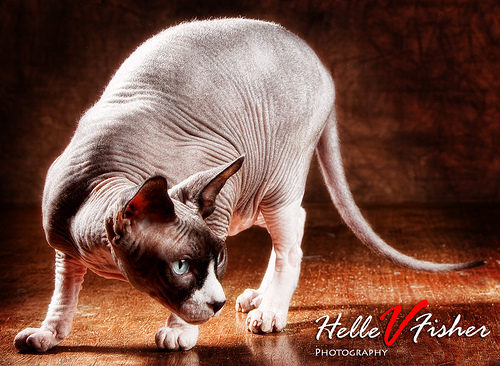

In [16]:
from IPython.display import Image
Image('images/Sphynx_143.jpg')

In [43]:
!python yolov5/train.py --img 416 --batch 64 --epochs 3 --data pet.yaml --weights /content/yolov5/runs/train/exp6/weights/best.pt

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=/content/yolov5/runs/train/exp6/weights/best.pt, cfg=, data=pet.yaml, hyp=yolov5/data/hyps/hyp.scratch.yaml, epochs=3, batch_size=64, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, entity=None, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1, freeze=0, patience=100
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 v5.0-486-gba99092 torch 1.9.0+cu102 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

hyperpa

In [51]:
import torch

# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=False)
model.load_state_dict(torch.load('/content/yolov5/runs/train/exp6/weights/best.pt'), strict=False)
model.eval()

for p in model.parameters():
    p.requires_grad = False

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master


requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...


YOLOv5 🚀 2021-9-30 torch 1.9.0+cu102 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)


                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Focus                     [3, 32, 3]                    
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  3    156928  models.common.C3                        [128, 128, 3]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  3    625152  models.common.C3                        [256, 256, 3]                 
  7                -1  1   1180672  models.common.Conv        


requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



 21                -1  1    590336  models.common.Conv                      [256, 256, 3, 2]              
 22          [-1, 10]  1         0  models.common.Concat                    [1]                           
 23                -1  1   1182720  models.common.C3                        [512, 512, 1, False]          
 24      [17, 20, 23]  1    229245  models.yolo.Detect                      [80, [[10, 13, 16, 30, 33, 23], [30, 61, 62, 45, 59, 119], [116, 90, 156, 198, 373, 326]], [128, 256, 512]]
Model Summary: 283 layers, 7276605 parameters, 7276605 gradients, 17.1 GFLOPs

Adding AutoShape... 
